# Guided Project: Predicting Bike Rentals

The work presented is part of a guided project where the data and model suggestions are given. All analysis work is my own.

## Goal

Predict the total number of bikes people rented in a given hour using different machine learning models. Three models will be considered:

* Linear regression
* Single decision tree
* Random forest

The dataset was compiled by Hadi Fanaee-T. Parameters include (from the README.txt file):

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : whether day is holiday or not
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

## Exploratory Analysis

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [68]:
bike_rentals = pd.read_csv("hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


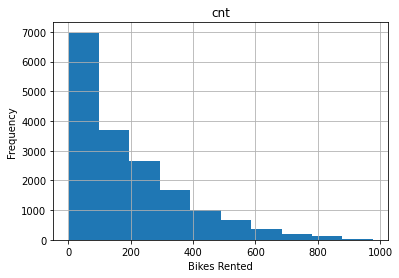

In [8]:
#distribution of total rentals
bike_rentals.hist("cnt")
plt.xlabel("Bikes Rented")
plt.ylabel("Frequency")
plt.show()

The distribution appears to be right-skewed where 0 to 100 bikes are most often used in any given hour.

In [9]:
#looking at correlations
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

<AxesSubplot:>

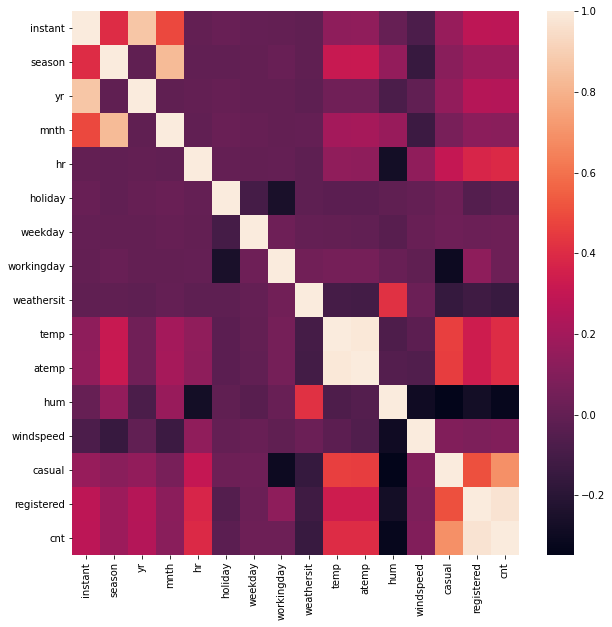

In [69]:
plt.figure(figsize=(10, 10))
sns.heatmap(bike_rentals.corr())

Casual and registered are correlated with count which is expected as these simply categorize the type of user. Features that may be of interest include hour, temperature and humidity as these are moderately correlated with count. 

Check for potential collinearity between feature columns which can lead to duplicate information being fed into the model. `temp` and `atemp` are mostly likely correlated.

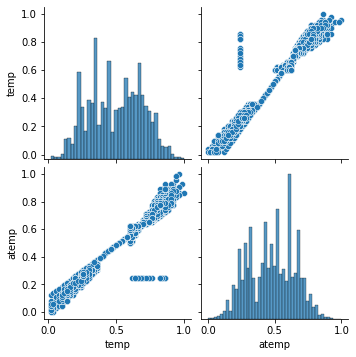

In [11]:
sns.pairplot(bike_rentals[["temp", "atemp"]])

In [12]:
#isolating the data points that do not lie on the approximate linear relationship
bike_rentals[(bike_rentals["atemp"] > 0.2) & (bike_rentals["atemp"] < 0.35) &(bike_rentals["temp"] > 0.6) &(bike_rentals["temp"] < 0.8)]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
14131,14132,2012-08-17,3,1,8,0,0,5,1,1,0.68,0.2424,0.57,0.1642,21,67,88
14132,14133,2012-08-17,3,1,8,1,0,5,1,1,0.66,0.2424,0.65,0.1045,16,38,54
14133,14134,2012-08-17,3,1,8,2,0,5,1,1,0.66,0.2424,0.61,0.1343,4,15,19
14134,14135,2012-08-17,3,1,8,3,0,5,1,1,0.64,0.2424,0.65,0.1045,0,6,6
14135,14136,2012-08-17,3,1,8,4,0,5,1,1,0.64,0.2424,0.73,0.1642,0,9,9
14136,14137,2012-08-17,3,1,8,5,0,5,1,1,0.64,0.2424,0.73,0.1045,2,34,36
14137,14138,2012-08-17,3,1,8,6,0,5,1,1,0.62,0.2424,0.78,0.1343,6,151,157
14138,14139,2012-08-17,3,1,8,7,0,5,1,1,0.64,0.2424,0.73,0.1045,11,368,379
14139,14140,2012-08-17,3,1,8,8,0,5,1,1,0.68,0.2424,0.65,0.1343,43,625,668
14140,14141,2012-08-17,3,1,8,9,0,5,1,1,0.70,0.2424,0.58,0.1045,58,320,378


There appears to be a strong linear relationship between `atemp` and `temp` suggesting that we do not need both in the model. There are a set of points that do not obey this linear relationship and appear as outliers. It seems limited to the data collected on 2012-08-17 (24 rows) which is small in comparison to the overall dataset and so these points will be discarded.  

In [13]:
bike_rentals = bike_rentals[bike_rentals["dteday"] != "2012-08-17"]

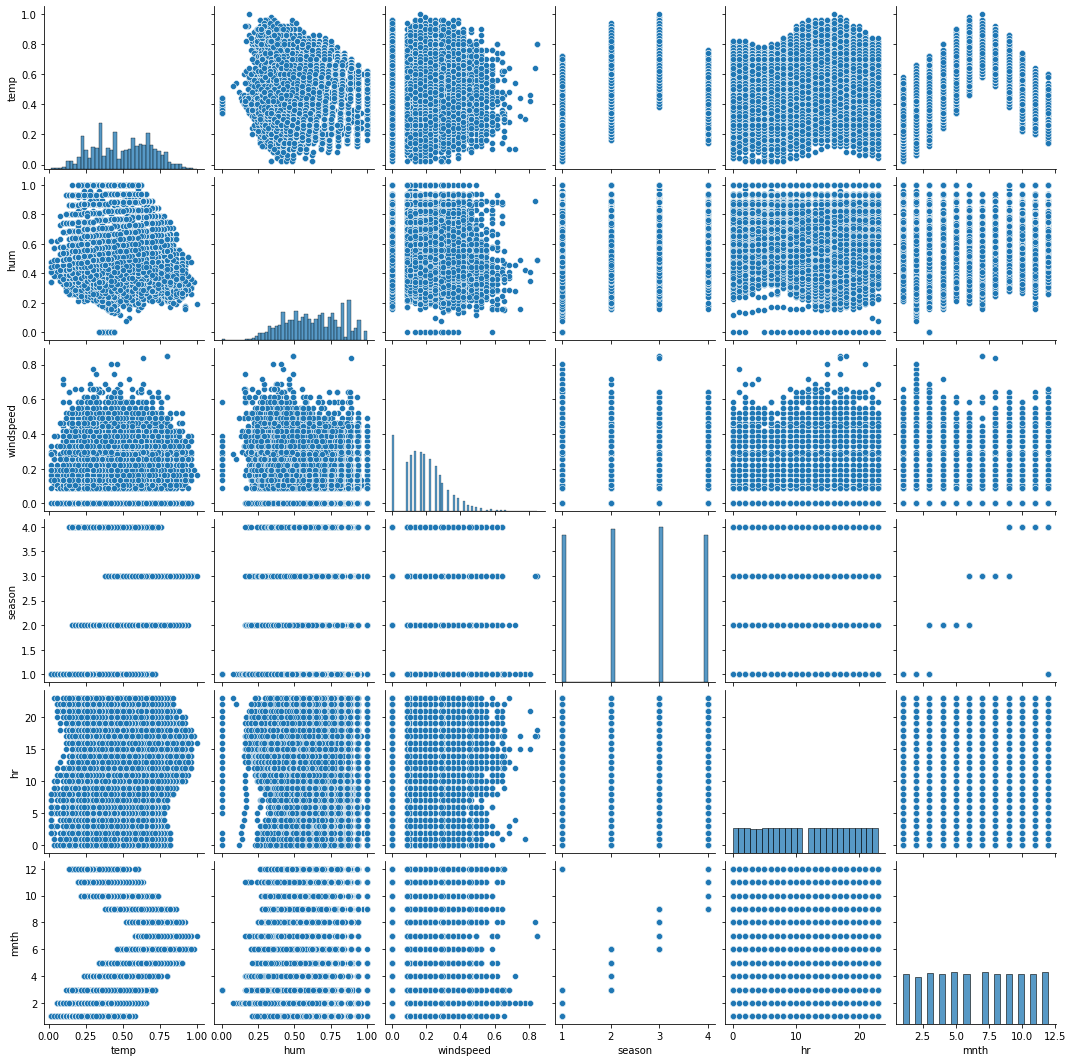

In [14]:
sns.pairplot(bike_rentals[["temp", "hum", "windspeed", "season", "hr", "mnth"]])

Looking at a pairplot of the weather features along with `mnth` and `hr`, there does not seem to be any significant linear relationships between the variables which would imply collinearity. There does seem to be a seasonal pattern in the temperature as the months change and a rise/falling pattern to the temperature over the course of a day. These are expected and it will be interesting to see if the bike counts follow a similar pattern.

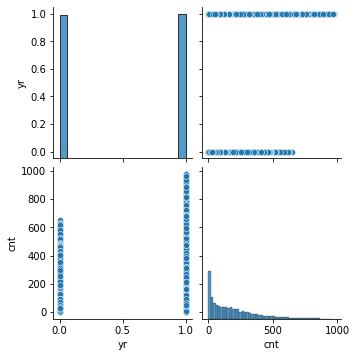

In [15]:
sns.pairplot(bike_rentals[["yr", "cnt"]])

It appears that the year makes a difference in the counts, this feature will also be included to train the models.

## Pre-processing

In [16]:
#grouping the hours together to form larger sections of time
def assign_label(hour):
    if 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    elif 18 <= hour < 24:
        return 3
    else:
        return 4
    
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [17]:
bike_rentals["holiday"].value_counts()

0    16855
1      500
Name: holiday, dtype: int64

The features that will be excluded to train the model include `instant`, `dteday`, `casual` and `registered` as the bike counts can be simply determined from these. `holiday` will be excluded because it is a feature that does not seem to vary enough (only 3% of the days are holidays which is quite low). `season` will also be removed as any effects may be seen using `mnth`. `weathersit` will also be removed as any effects may be contained within `hum`, `temp` and `windspeed`. 

In [18]:
features = ["temp", "hum", "windspeed", "time_label", "hr", "mnth", "yr", "weekday", "workingday"]

#the weather features seem to range from 0 to 1 already and so do not need to be normalized
#the other features are ordinal and have been label-encoded

In [19]:
#split data into training and test sets
#train on 80% of the data, use remaining 20% as the test set
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Error metric

The error metric that will be used to compare the models will be the root mean squared error (RMSE) as `cnt` (the variable we are trying to predict) is continous. This metric will penalize predicted values that are farther away from the true value and the units of the errors will be in same units as `cnt`.

## 1. Linear Regression Model

In [20]:
lr = LinearRegression()

lr.fit(train[features], train["cnt"])

LinearRegression()

In [21]:
predictions = lr.predict(test[features])

In [22]:
mse = mean_squared_error(test["cnt"], predictions)

In [23]:
np.sqrt(mse)

135.62409038588143

Text(0, 0.5, 'cnt')

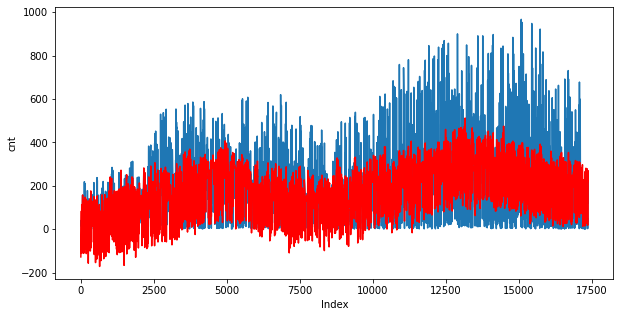

In [24]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test[["cnt"]])
plt.plot(test.index, predictions, c="red")
plt.xlabel("Index")
plt.ylabel("cnt")

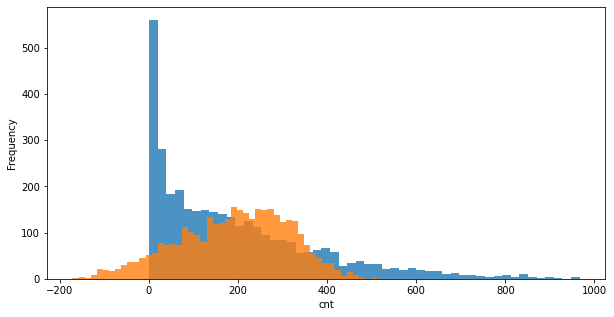

In [25]:
plt.figure(figsize=(10,5))
plt.hist(test["cnt"], alpha=0.8, bins=50)
plt.hist(predictions, alpha=0.8, bins=50)
plt.xlabel("cnt")
plt.ylabel("Frequency")
plt.show()

This model is not very good, it predicts values that are consistently lower than the true values. It also predicts negative counts which is not physically possible and the frequency distributions of `cnt` do not match well.

## 2. Single Decision Tree Model

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
dreg = DecisionTreeRegressor()

In [28]:
dreg.fit(train[features], train["cnt"])

DecisionTreeRegressor()

In [29]:
predictions_dt = dreg.predict(test[features])
predictions_dt_train = dreg.predict(train[features])

In [30]:
mse_dt = mean_squared_error(test["cnt"], predictions_dt)
mse_dt_train = mean_squared_error(train["cnt"], predictions_dt_train)

In [31]:
np.sqrt(mse_dt)

63.82100019792329

In [32]:
np.sqrt(mse_dt_train)

0.9517304441779237

This model is quite a bit better than the linear regression model. However, the large difference between the training error and the test error shows that the model is overfitting. 

### 2b. Decision Tree - Second Trial

In [33]:
dreg.tree_.max_depth

29

The max depth for the default generated tree is 29. Reduce this to 10 to see the result.

In [34]:
dreg2 = DecisionTreeRegressor(max_depth=10)
dreg2.fit(train[features], train["cnt"])
predictions_dt2 = dreg2.predict(test[features])
predictions_dt2_train = dreg2.predict(train[features])

In [35]:
mse_dt2 = mean_squared_error(test["cnt"], predictions_dt2)
mse_dt2_train = mean_squared_error(train["cnt"], predictions_dt2_train)

In [36]:
np.sqrt(mse_dt2)

62.46956883727684

In [37]:
np.sqrt(mse_dt2_train)

51.08676549475123

The training and test errors are now relatively close which ensures that the model is not overfitting to the training data.

### 2c. Decision Tree - Third Trial

Try tweaking `min_samples_leaf` as well. Note that increasing this value (default of 1) too much will make the leafs too general leading to inaccurate predictions.

In [39]:
dreg3 = DecisionTreeRegressor(min_samples_leaf=10)
dreg3.fit(train[features], train["cnt"])
predictions_dt3 = dreg3.predict(test[features])
predictions_dt3_train = dreg3.predict(train[features])

In [40]:
mse_dt3 = mean_squared_error(test["cnt"], predictions_dt3)
mse_dt3_train = mean_squared_error(train["cnt"], predictions_dt3_train)

In [41]:
np.sqrt(mse_dt3)

56.57560778270445

In [42]:
np.sqrt(mse_dt3_train)

45.37794837003567

Both the training and test errors are improved over the 2b model.

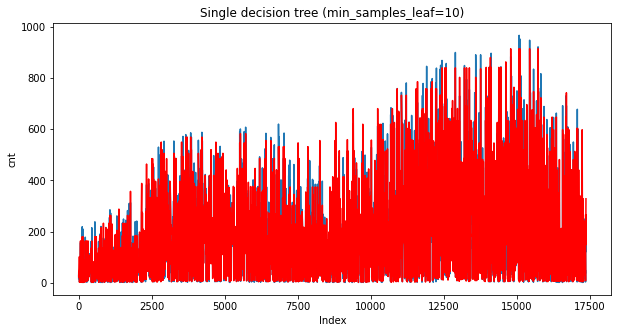

In [43]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test[["cnt"]])
plt.plot(test.index, predictions_dt3, c="red")
plt.xlabel("Index")
plt.ylabel("cnt")
plt.title("Single decision tree (min_samples_leaf=10)")
plt.show()

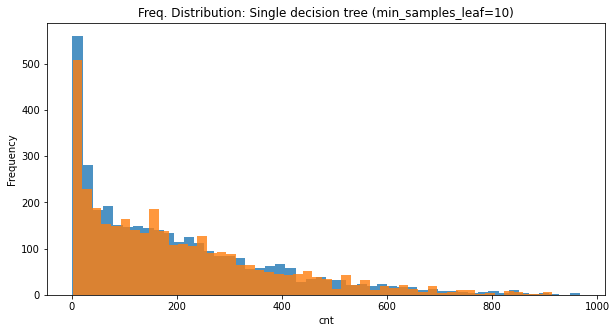

In [45]:
plt.figure(figsize=(10,5))
plt.hist(test["cnt"], alpha=0.8, bins=50)
plt.hist(predictions_dt3, alpha=0.8, bins=50)
plt.xlabel("cnt")
plt.ylabel("Frequency")
plt.title("Freq. Distribution: Single decision tree (min_samples_leaf=10)")
plt.show()

The single decision tree model is able to predict the bike counts well and capture the frequency distribution of the counts.

## 3. Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rf = RandomForestRegressor()
rf.fit(train[features], train["cnt"])
predictions_rf = rf.predict(test[features])
predictions_rf_train = rf.predict(train[features])

In [48]:
mse_rf = mean_squared_error(test["cnt"], predictions_rf)
mse_rf_train = mean_squared_error(train["cnt"], predictions_rf_train)

In [49]:
np.sqrt(mse_rf)

47.5747844734406

In [50]:
np.sqrt(mse_rf_train)

17.90910253744064

This is significantly better than the single decision tree model, however the model may be overfitting due to the low training error.

### 3b. Random Forest - Second Trial

In [59]:
#Try tweaking `min_samples_leaf` and noting the results.
rf2 = RandomForestRegressor(min_samples_leaf=5)
rf2.fit(train[features], train["cnt"])
predictions_rf2 = rf2.predict(test[features])
predictions_rf2_train = rf2.predict(train[features])

In [60]:
mse_rf2 = mean_squared_error(test["cnt"], predictions_rf2)
mse_rf2_train = mean_squared_error(train["cnt"], predictions_rf2_train)

In [61]:
np.sqrt(mse_rf2)

50.02524758419922

In [62]:
np.sqrt(mse_rf2_train)

37.191419225049955

The test error is relatively the same as the last model and the training error has increased suggesting the the model is not overfitting anymore.

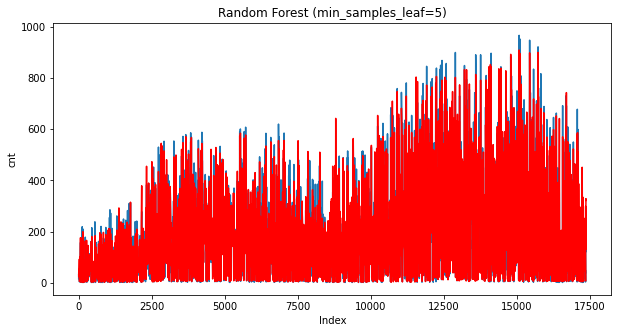

In [65]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test[["cnt"]])
plt.plot(test.index, predictions_rf2, c="red")
plt.xlabel("Index")
plt.ylabel("cnt")
plt.title("Random Forest (min_samples_leaf=5)")
plt.show()

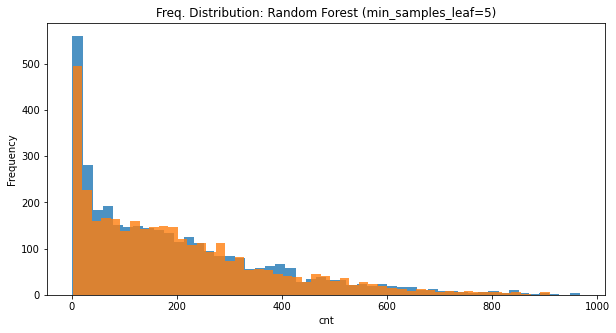

In [66]:
plt.figure(figsize=(10,5))
plt.hist(test["cnt"], alpha=0.8, bins=50)
plt.hist(predictions_rf2, alpha=0.8, bins=50)
plt.xlabel("cnt")
plt.ylabel("Frequency")
plt.title("Freq. Distribution: Random Forest (min_samples_leaf=5)")
plt.show()

The Random Forest model is able to predict the bike counts well and capture the frequency distribution of the counts. It results in training and test errors that are smaller than the single decision tree model due to the averaging of several trees created.